In [ ]:
## notebook variant
variant = 'CV_gene_median_aboveorequalto1_normalized_mtx'
#path = plot_save_path

In [5]:
library(ggplot2)
library(Hmisc)
library(ggpubr)
library(stringr)
library(scales)
library(parallel)
library(cvequality)
library(readxl)
library(tibble)
library(pbapply)
library(qvalue)
library(gplots)
library(stats)
library(reshape2)
library(gridExtra)
library(Seurat)
library(Matrix)
library(sparseMatrixStats)
library(dplyr)
library(ComplexHeatmap)
library(viridis)

Loading required package: lattice

Loading required package: survival

Loading required package: Formula


Attaching package: ‘Hmisc’


The following objects are masked from ‘package:base’:

    format.pval, units



Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess



Attaching package: ‘Seurat’


The following object is masked from ‘package:Hmisc’:

    Key



Attaching package: ‘dplyr’


The following object is masked from ‘package:gridExtra’:

    combine


The following objects are masked from ‘package:Hmisc’:

    src, summarize


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: grid

ComplexHeatmap version 2.2.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-

In [ ]:
### load in Seurat data that has been pre-processesed for high quality cells ###
## In this notebook guide RNAs are essentially samples, and can be used interchangeably 
## Seurat_object input

In [ ]:
# Seurat_object = your_seurat_object
Seurat_object <- NormalizeData(Seurat_object, normalization.method = 'RC')
filtered_raw_mtx <- Seurat_object@assays$RNA@data
medians = sparseMatrixStats::rowMedians(filtered_raw_mtx)
median_df = data.frame(gene_medians = medians)

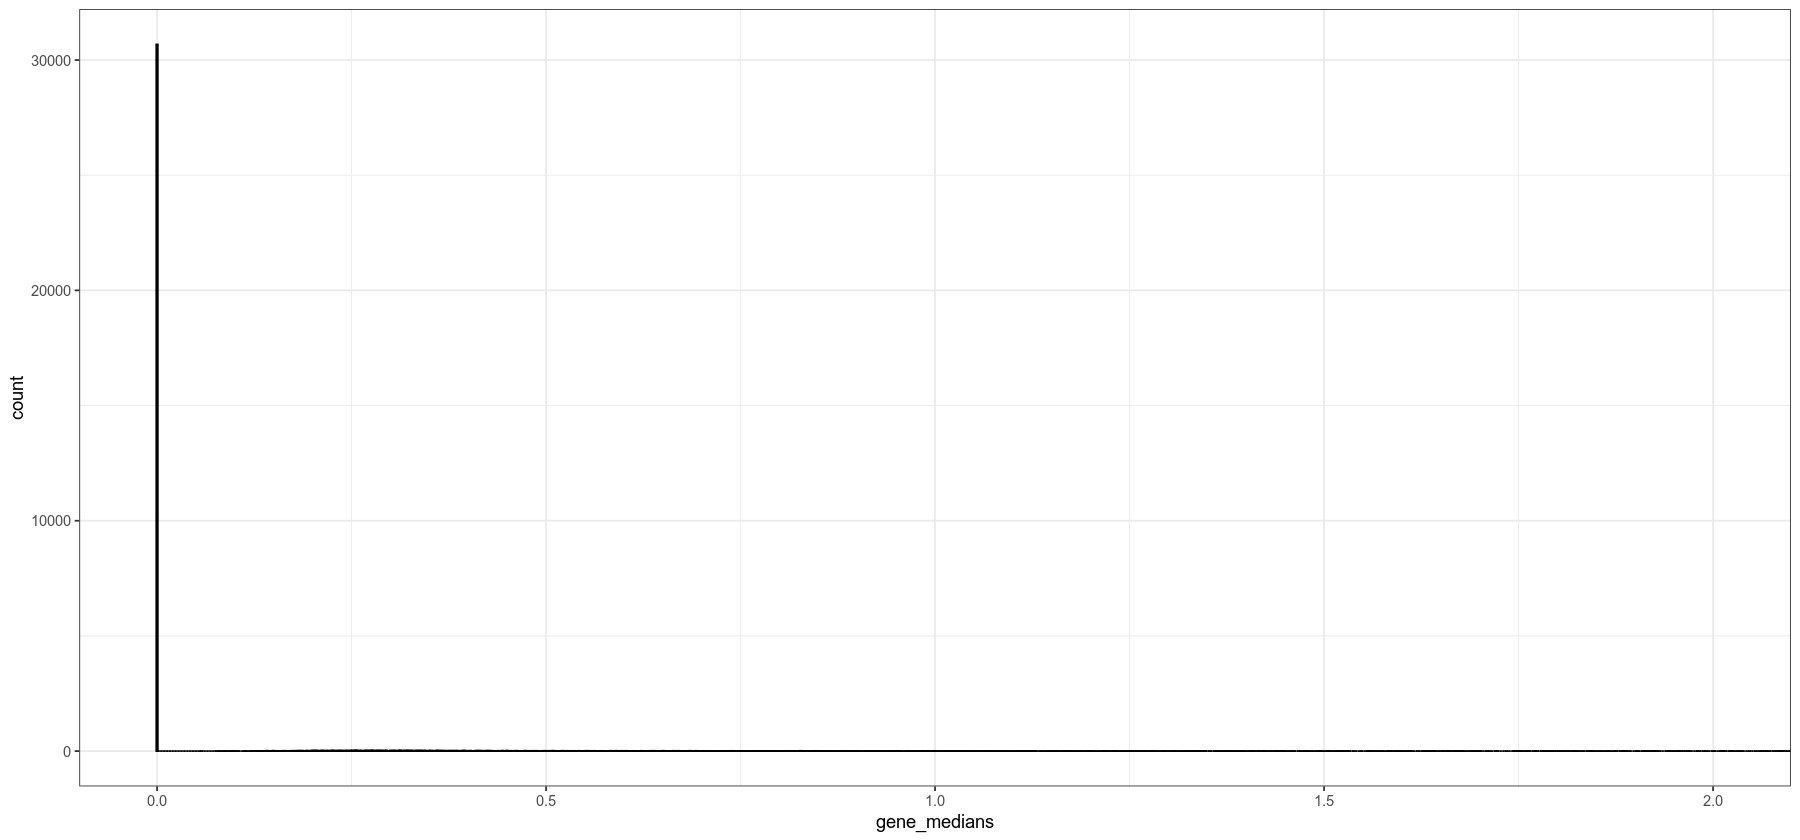

In [19]:
ggplot(median_df, aes(x=gene_medians)) + 
  geom_histogram(color="black", fill="white", bins = 50000) +
  geom_vline(xintercept = 10, color = 'blue') + coord_cartesian(xlim = c(0,2)) +
  theme_bw()

In [20]:
pct_genes_left = function(median_expression, cutoff){
  pct = 100*length(which(median_expression >= cutoff))/length(median_expression)
  return(pct)
}

pct_genes_left(medians, 0.1)

[1] 16.14983

In [ ]:
#### Parameter cell ####
### removing genes with medians < 0.1 keeps 16% of genes -- low expressing genes have noisy expression and confound results ###
filtered_meta_data <- Seurat_object@meta.data
genes_to_keep = as.numeric(medians) >= 0.1 ## parameter
filtered_raw_mtx <- Seurat_object@assays$RNA@data[genes_to_keep,]
filtered_meta_data <- filtered_meta_data[colnames(filtered_raw_mtx),]

used_genes = rownames(filtered_raw_mtx)
path = paste0(path, variant, 'CRISPRi_used_genes.rds')
saveRDS(used_genes, path)

In [23]:
dim(filtered_raw_mtx)

[1] 5911 6975

In [ ]:
### Parameter cell ###
## make sure to change the metadata column containing sample name to 'guide' for notebook to run ##

## cells per guide count
guides = unique(filtered_meta_data$guide)

cells_per_guide = vector()
for (i in 1:length(guides)){
    cells_per_guide[i] = length(which(filtered_meta_data$guide == guides[i]))
}

cell_gd_count = data.frame(guide_name = guides, cell_count = cells_per_guide)

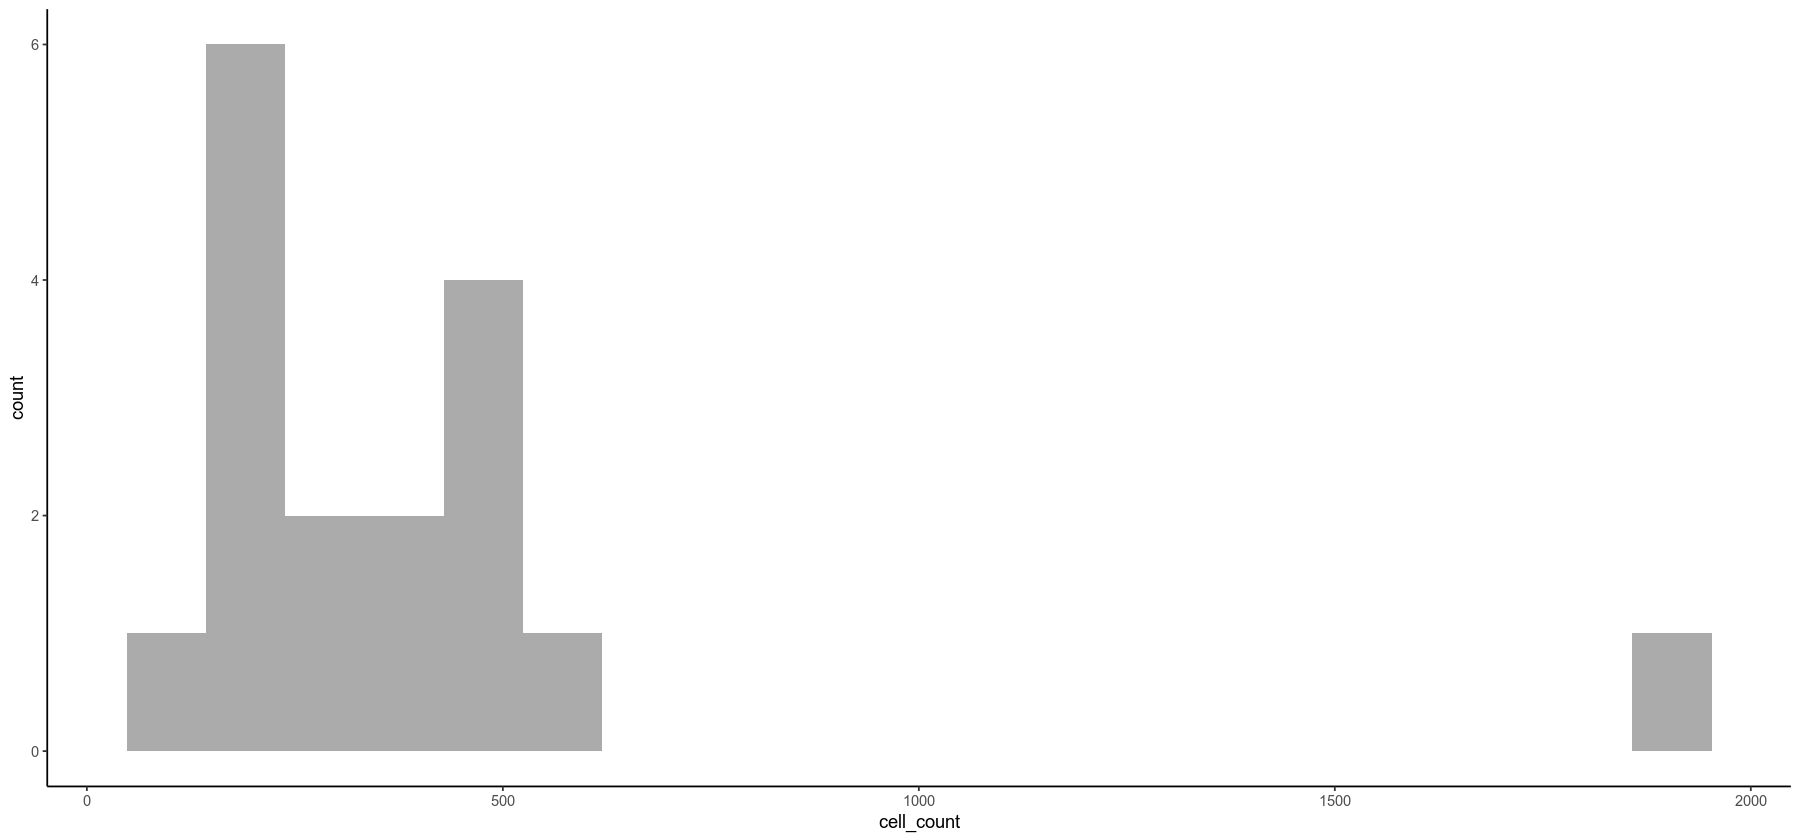

In [ ]:
### show distribution of cells per guide

ggplot(cell_gd_count, aes(x=cell_count)) +
geom_histogram(position="identity", alpha=0.5, bins = 20) +
theme_classic()

In [26]:
arrange(cell_gd_count, cell_count)

guide_name,cell_count
<fct>,<int>
AURKB,90
CENPN,187
CDK1,192
HJURP,212
SUPV3L1,216
AURKA,227
ENY2,232
RUVBL1,274
CENPM,328


In [27]:
### divide expression mtx into a list of mtxs subsetted by guide

mtx_subsetter = function(guide_nm, matrix, meta_data){
    return(matrix[, meta_data$guide == guide_nm])}

guide_subsetted_data = pblapply(X = guides, FUN = mtx_subsetter, 
                                matrix = filtered_raw_mtx, meta_data = filtered_meta_data)

names(guide_subsetted_data) = guides

In [ ]:
#### Parameter cell ####
## control number of cells per guide to be equivalent
## throw out guides with < 90 cells and for the remaining guides sample 90 cells without replacement
fixed_cell_count = 90 ## parameter
guide_subsetted_data = guide_subsetted_data[cells_per_guide >= fixed_cell_count]
cells_to_discard = list()

set.seed(22)
for (i in 1:length(guide_subsetted_data)){
    idx_to_keep = sample(1:ncol(guide_subsetted_data[[i]]), fixed_cell_count, replace = FALSE)
    idx_to_discard = setdiff(1:ncol(guide_subsetted_data[[i]]), idx_to_keep)
    cells_to_discard[[i]] = colnames(guide_subsetted_data[[i]])[idx_to_discard]
    guide_subsetted_data[[i]] = guide_subsetted_data[[i]][,idx_to_keep]
}

cells_to_discard = unlist(cells_to_discard)

In [29]:
## add bkg distribution of guide subsetted mtxs to list
## this is just mtxs where the cells are randomly assigned to each guide
## the bkg distribution of mtxs is made to subtract out number of genes that are expected to have increased or decreased CV when cells assigned randomly to each guide
## Note: the number of cells assigned to each guide is kept the same
set.seed(44)

randomized_filtered_raw_mtx = Reduce(cbind, guide_subsetted_data[names(guide_subsetted_data) != "NT"])
randomized_cell_order = sample(colnames(randomized_filtered_raw_mtx), ncol(randomized_filtered_raw_mtx), replace = FALSE)


designation_vector = mapply(rep, guides[guides != 'NT'], fixed_cell_count, SIMPLIFY = TRUE)
designation_vector = unlist(designation_vector)
designation_vector = as.character(designation_vector)
split_barcodes = split(randomized_cell_order, designation_vector)
mtx_random_splitter = function(barcodes, mtx){return(mtx[,barcodes])}

guide_random_subsetted_data = pblapply(X = split_barcodes, FUN = mtx_random_splitter, mtx = randomized_filtered_raw_mtx)
guide_random_subsetted_data = c(guide_subsetted_data[names(guide_subsetted_data) == "NT"], guide_random_subsetted_data)
names(guide_random_subsetted_data) = paste('random', c('NT', guides[guides != 'NT']), sep = '_')
guide_subsetted_data = c(guide_subsetted_data, guide_random_subsetted_data)

In [30]:
## compare each of the guide subsetted data to the control subsetted data and
## create the following table for each guide:
## gene | CV1 (ctrl) | CV2 (gd) | CV2/CV1 | Increasing or Decreasing CV (ie CV2/CV1 > 1 or CV2/CV1 < 1) | asymptotic test p-value | q-value 


## CV calculator
CV_calculator = function(x){return((sparseMatrixStats::rowSds(x))/(sparseMatrixStats::rowMeans2(x)))}
CVs = pblapply(X = guide_subsetted_data, FUN = CV_calculator)
names(CVs) = names(guide_subsetted_data)

In [31]:
### creating first 4 columns of the table annotated above
gene_means = lapply(guide_subsetted_data, sparseMatrixStats::rowMeans2)
gene_sds = lapply(guide_subsetted_data, sparseMatrixStats::rowSds)
names(gene_means) = names(guide_subsetted_data)
names(gene_sds) = names(guide_subsetted_data)


master_df_list = list()
for (i in 1:length(guide_subsetted_data)){
    if (!startsWith(names(guide_subsetted_data)[i], 'random')){
        master_df_list[[i]] = data.frame(gene = rownames(filtered_raw_mtx), CV_ctrl = CVs[['NT']], 
                                         CV_gd = CVs[[i]], CV_gdCV_ctrlratio = CVs[[i]]/CVs[['NT']], mean_gdmean_ctrlratio = gene_means[[i]]/gene_means[['NT']])
        names(master_df_list)[i] <- names(guide_subsetted_data)[i]
    }
    if (startsWith(names(guide_subsetted_data)[i], 'random')){
        master_df_list[[i]] = data.frame(gene = rownames(filtered_raw_mtx), CV_ctrl = CVs[['NT']], 
                                         CV_gd = CVs[[i]], CV_gdCV_ctrlratio = CVs[[i]]/CVs[['NT']], mean_gdmean_ctrlratio = gene_means[[i]]/gene_means[['NT']])
        names(master_df_list)[i] <- names(guide_subsetted_data)[i]
    }
}



In [32]:
### creating column 5 of the table annotated above
for (i in 1:length(master_df_list)){
    master_df_list[[i]]$gene_status = 'NA'
    master_df_list[[i]]$gene_status[master_df_list[[i]]$CV_gdCV_ctrlratio == 1] = 'No Change'
    master_df_list[[i]]$gene_status[master_df_list[[i]]$CV_gdCV_ctrlratio > 1] = 'Increasing'
    master_df_list[[i]]$gene_status[master_df_list[[i]]$CV_gdCV_ctrlratio < 1] = 'Decreasing'               
}


In [ ]:
## performing CV equality aysmptotic test and adding its pval to master_df_list
cells_per_guide = rep(cells_per_guide, 2)
names(cells_per_guide) = names(guide_subsetted_data)
asymp_test_p_vals = as.data.frame(matrix(0, nrow = nrow(filtered_raw_mtx), ncol = length(master_df_list)))


for (i in 1:length(master_df_list)){
    if (!startsWith(names(guide_subsetted_data)[i], 'random')){
        for (j in 1:nrow(filtered_raw_mtx)){
            test = asymptotic_test2(k = 2, n = c(cells_per_guide['NT'], cells_per_guide[i]), s = c(gene_sds[['NT']][j], gene_sds[[i]][j]), 
                                    x = c(gene_means[['NT']][j], gene_means[[i]][j]))
            asymp_test_p_vals[j,i] = test$p_value
        }
    }
    if (startsWith(names(guide_subsetted_data)[i], 'random')){
        for (j in 1:nrow(filtered_raw_mtx)){
            test = asymptotic_test2(k = 2, n = c(cells_per_guide['NT'], cells_per_guide[i]), s = c(gene_sds[['NT']][j], gene_sds[[i]][j]), 
                                    x = c(gene_means[['NT']][j], gene_means[[i]][j]))
            asymp_test_p_vals[j,i] = test$p_value
        }    
    }
    master_df_list[[i]]$p_val = asymp_test_p_vals[,i]
}

# saveRDS(master_df_list, paste0(path, variant, 'CV_ratios.rds'))

In [ ]:
## ***
## pick relevant assay in FindMarkers
## Find genes that see a significant change in mean from NT control
pbo = pboptions(type="txt")
cells_to_keep_from_fixed_cell_count <- colnames(Reduce(cbind, guide_subsetted_data[guides]))


Idents(object = Seurat_object) <- Seurat_object@meta.data$guide
Seurat_object = Seurat_object[genes_to_keep, cells_to_keep_from_fixed_cell_count]

find_markers_wrapper = function(perturbed_gene){
                                      FindMarkers(Seurat_object, ident.1 = 'NT', ident.2 = perturbed_gene, test.use = 't', verbose = FALSE)
}

mean_shifts_from_NT = pblapply(guides[guides != 'NT'], find_markers_wrapper)
names(mean_shifts_from_NT) = guides[guides != 'NT']

## Find genes that see signinficant change in mean from control in bkg (randomized cell labels)

Seurat_object_random = Seurat_object
meta_temp = Seurat_object_random@meta.data
meta_temp[randomized_cell_order, 'guide'] = designation_vector
Seurat_object_random@meta.data = meta_temp

find_markers_wrapper_random = function(perturbed_gene){
                                      FindMarkers(Seurat_object_random, ident.1 = 'NT', ident.2 = perturbed_gene, test.use = 't', verbose = FALSE)
}

mean_shifts_from_NT_bkg = pblapply(guides[guides != 'NT'], find_markers_wrapper_random)
names(mean_shifts_from_NT_bkg) = paste('random', sep = '_', guides[guides != 'NT'])

mean_shifts_from_NT = c(mean_shifts_from_NT, mean_shifts_from_NT_bkg)

  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100%
  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100%


## Comparing guide CV and NT guide CV ratios

In [35]:
plotted_guides = names(master_df_list)[!(names(master_df_list) %in% c('NT', 'random_NT'))]
plotted_guides_with_NT = names(master_df_list)
ratios = lapply(names(master_df_list), function(x){master_df_list[[x]]$CV_gdCV_ctrlratio})
names(ratios) = plotted_guides_with_NT
ratios_df <- as.data.frame(do.call(cbind, ratios))
colnames(ratios_df) = names(master_df_list)
ratios_df = ratios_df[, !(colnames(ratios_df) %in% c('NT', 'random_NT'))]
ratios_df = tidyr::pivot_longer(ratios_df, cols = colnames(ratios_df), values_to = 'CV_gdCV_ctrlratio', names_to = 'guide')
order_of_guides = ratios_df %>% group_by(guide) %>% summarize(means = mean(CV_gdCV_ctrlratio)) %>% arrange(means) %>% pull(guide) %>% as.character()
ratios_df$guide = factor(ratios_df$guide, levels = order_of_guides)

In [36]:
ratios = ratios[order_of_guides]
tests = lapply(ratios, t.test, mu = 1)
pvals = as.numeric(lapply(tests, function(x) return(x$p.val)))
pvals_adj = signif(p.adjust(pvals), 4)
pvals_adj[pvals_adj == 0] = '< e-300'

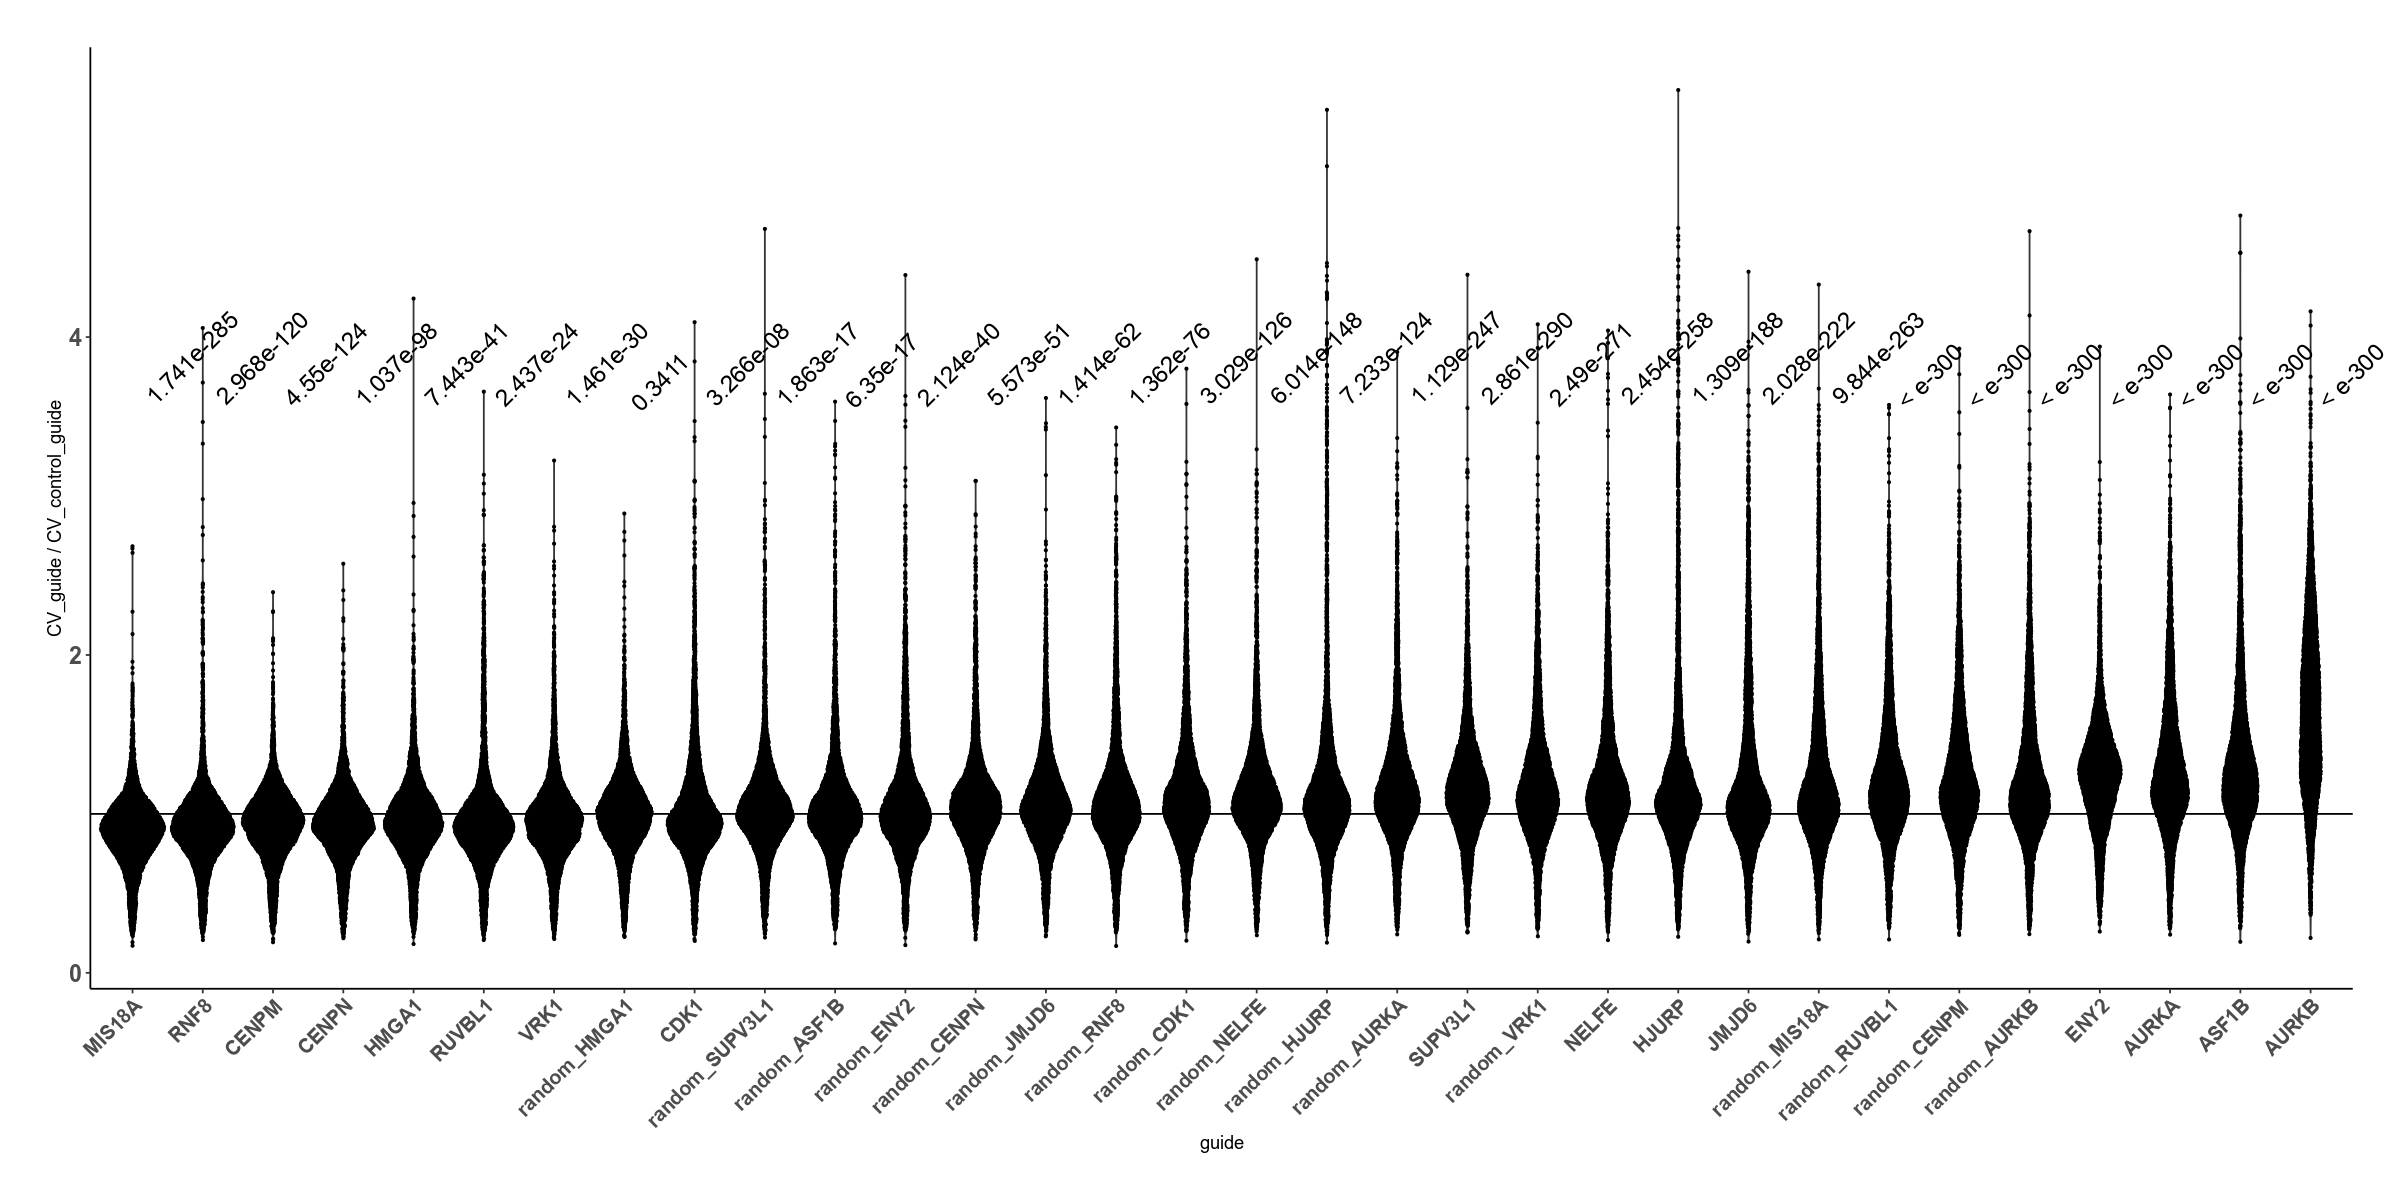

In [37]:
options(repr.plot.width=20, repr.plot.height=10)
library(ggforce)
plotted_guides = names(master_df_list)[!(names(master_df_list) %in% c('NT', 'random_NT'))]
ggplot(ratios_df, aes(guide, CV_gdCV_ctrlratio, fill = guide)) + ylab('CV_guide / CV_control_guide') +
  geom_violin(position=position_dodge()) + annotate("text", x = 1:length(plotted_guides), y = 3.5, size = 5, angle='45', hjust = -0.2, label = pvals_adj) +
  geom_sina(position=position_dodge(), size = 0.5) + geom_hline(yintercept = 1) + coord_cartesian(clip = 'off') +
  theme_classic() + theme(plot.margin = margin(1,1,1,1, "cm"), plot.title = element_text(hjust = 0.5), legend.position = 'none', axis.text.y = element_text(face = 'bold', size = 14), axis.text.x = element_text(face = 'bold', size = 12, angle = 45, hjust = 1))

In [ ]:
path = paste0(path, variant, 'violin_CV_ratio.pdf')
#ggsave(path, height = 10, width = 20)

In [39]:
plotted_guides = names(master_df_list)[!(names(master_df_list) %in% c('NT', 'random_NT'))]
plotted_guides_with_NT = names(master_df_list)
ratios = lapply(names(master_df_list), function(x){log2(master_df_list[[x]]$CV_gdCV_ctrlratio)})
names(ratios) = plotted_guides_with_NT
ratios_df <- as.data.frame(do.call(cbind, ratios))
colnames(ratios_df) = names(master_df_list)
ratios_df = ratios_df[, !(colnames(ratios_df) %in% c('NT', 'random_NT'))]
ratios_df = tidyr::pivot_longer(ratios_df, cols = colnames(ratios_df), values_to = 'CV_gdCV_ctrlratio', names_to = 'guide')
order_of_guides = ratios_df %>% group_by(guide) %>% summarize(means = mean(CV_gdCV_ctrlratio)) %>% arrange(means) %>% pull(guide) %>% as.character()
ratios_df$guide = factor(ratios_df$guide, levels = order_of_guides)

In [40]:
ratios = ratios[order_of_guides]
tests = lapply(ratios, t.test, mu = 0)
pvals = as.numeric(lapply(tests, function(x) return(x$p.val)))
pvals_adj = signif(p.adjust(pvals), 4)
pvals_adj[pvals_adj == 0] = '< e-300'

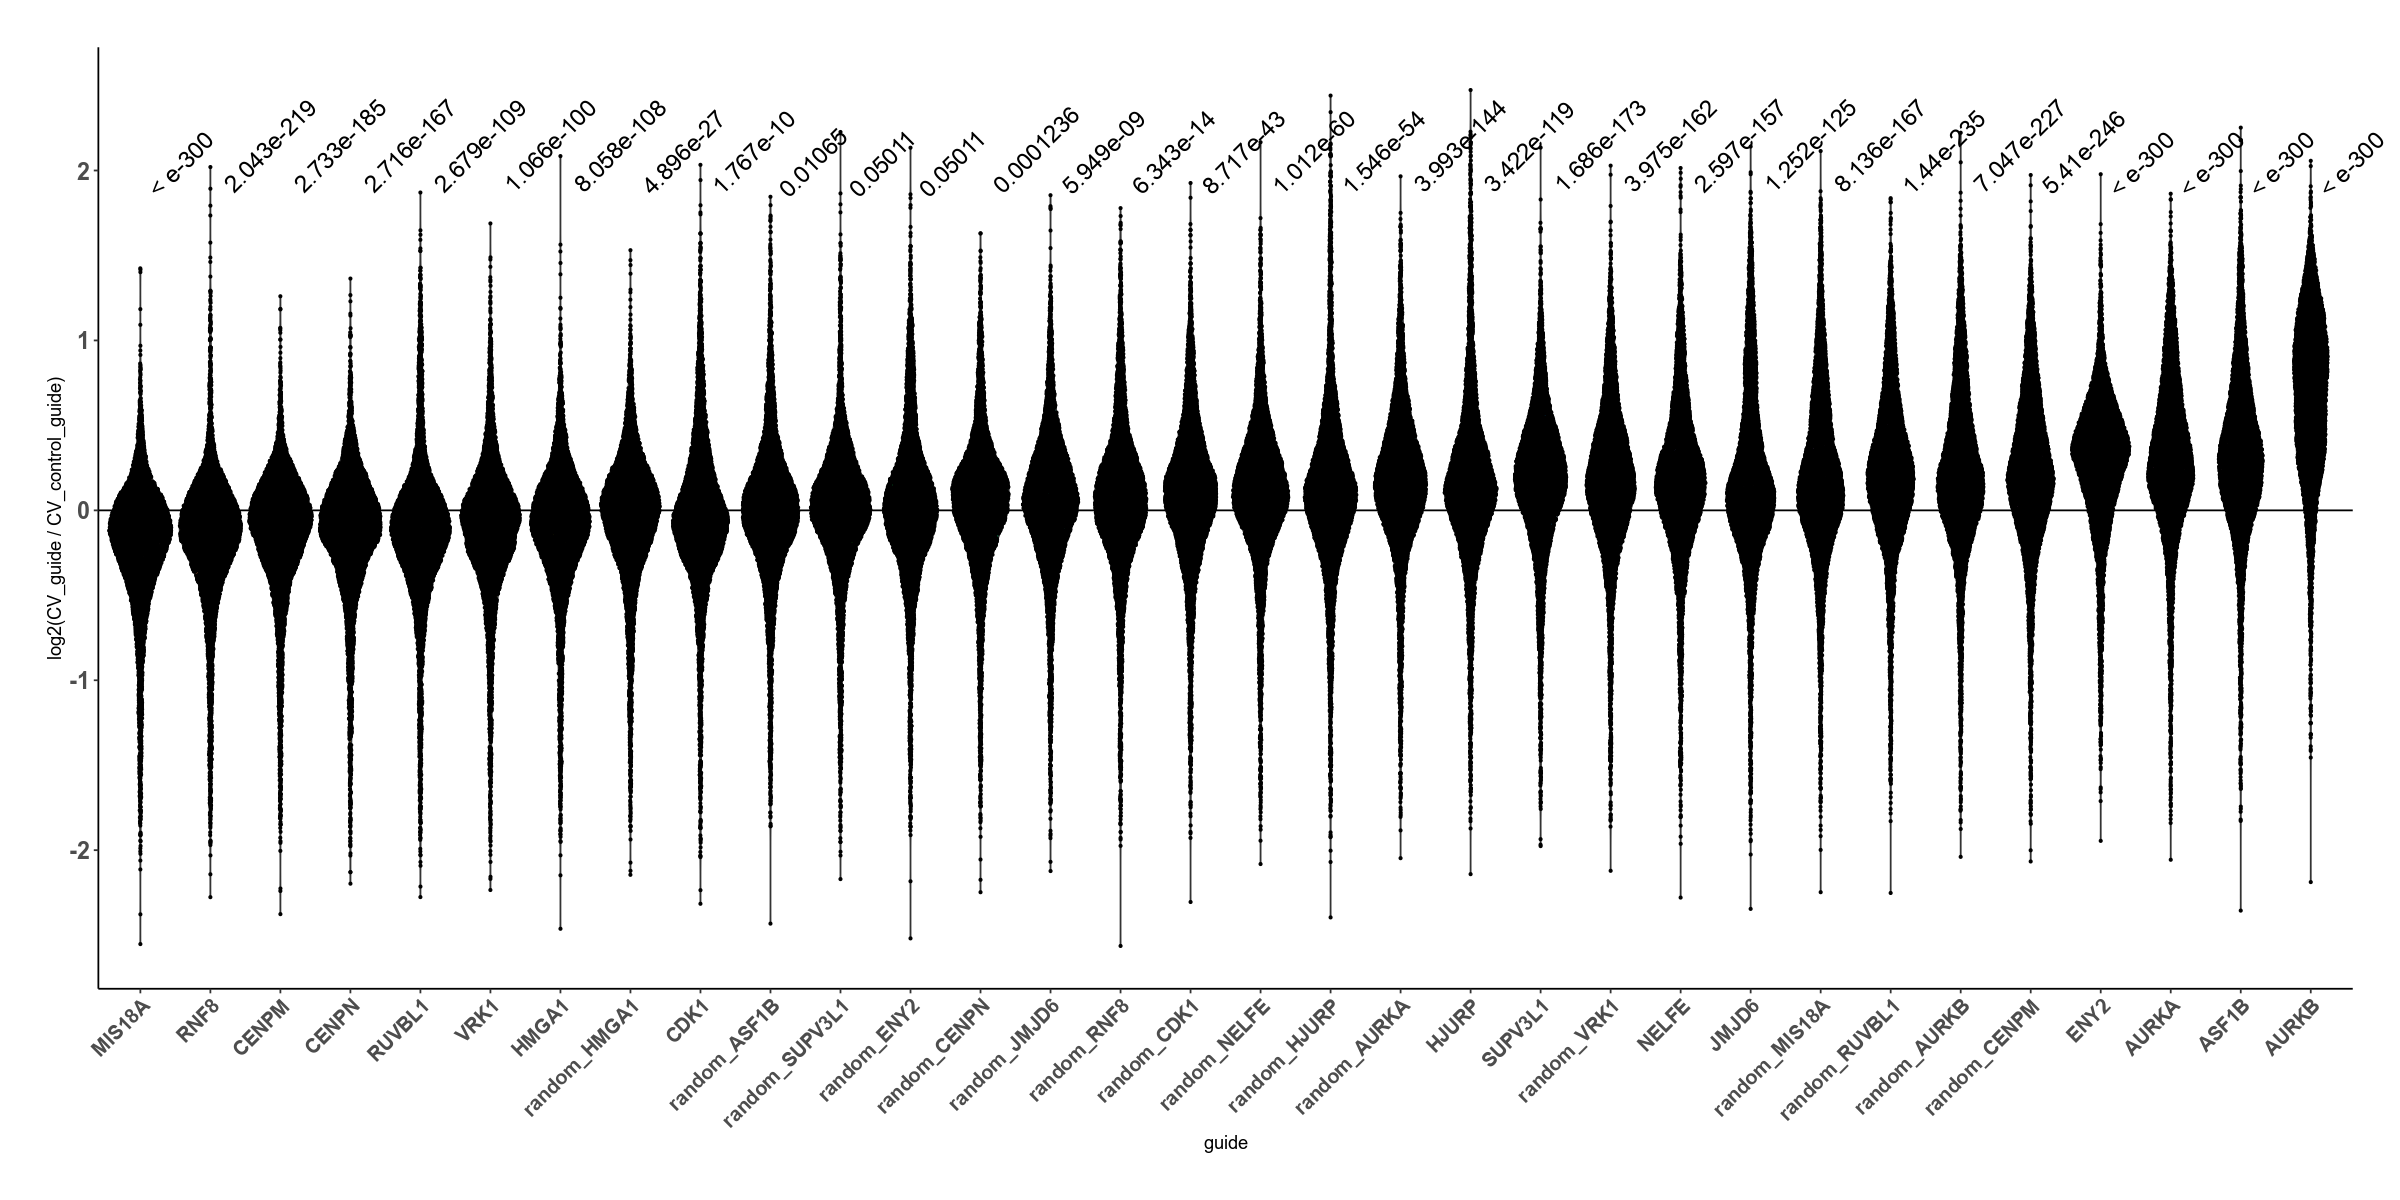

In [ ]:
options(repr.plot.width=20, repr.plot.height=10)
library(ggforce)

ggplot(ratios_df, aes(guide, CV_gdCV_ctrlratio, fill = guide)) + ylab('log2(CV_guide / CV_control_guide)') +
  geom_violin(position=position_dodge()) + annotate("text", x = 1:length(plotted_guides), y = 1.8, size = 5, angle='45', hjust = -0.2, label = pvals_adj) +
  geom_sina(position=position_dodge(), size = 0.5) + geom_hline(yintercept = 0) + coord_cartesian(clip = 'off') +
  theme_classic() + theme(plot.margin = margin(1,1,1,1, "cm"), plot.title = element_text(hjust = 0.5), legend.position = 'none', axis.text.y = element_text(face = 'bold', size = 14), axis.text.x = element_text(face = 'bold', size = 12, angle = 45, hjust = 1)) 

In [ ]:
path = paste0(path, variant, 'violin_CV_ratio_log2.pdf')
#ggsave(path, height = 10, width = 20)

In [44]:
## ks.test volcano plot for CV guide vs CV control guide -- KS test is better than Chi-square test for this data
ks.tests = lapply(CVs[!names(CVs) %in% c('NT', 'random_NT')], ks.test, y = CVs[['NT']])
ks.tests.pvals = lapply(ks.tests, function(x) return(x$p.value))
ks.tests.pvals_adj = signif(p.adjust(ks.tests.pvals), 4)
ks.tests.pvals_adj[ks.tests.pvals_adj == 0] = 10^-50
ks.tests.pvals_adj

NELFE         MIS18A        SUPV3L1           CDK1           VRK1 
     1.000e-50      1.000e-50      1.000e-50      1.436e-05      1.000e-50 
         JMJD6          HMGA1          HJURP          CENPM           RNF8 
     1.000e-50      1.000e-50      1.000e-50      1.000e-50      1.000e-50 
          ENY2          CENPN          ASF1B          AURKA         RUVBL1 
     1.000e-50      1.000e-50      1.000e-50      1.000e-50      1.000e-50 
         AURKB   random_NELFE  random_MIS18A random_SUPV3L1    random_CDK1 
     1.000e-50      1.000e-50      1.000e-50      7.238e-02      1.000e-50 
   random_VRK1   random_JMJD6   random_HMGA1   random_HJURP   random_CENPM 
     1.000e-50      4.079e-08      1.039e-03      1.000e-50      1.000e-50 
   random_RNF8    random_ENY2   random_CENPN   random_ASF1B   random_AURKA 
     1.949e-07      7.079e-02      2.646e-06      6.202e-01      1.000e-50 
 random_RUVBL1   random_AURKB 
     1.000e-50      1.000e-50

## Comparing guide mean and NT guide mean ratios

In [55]:
plotted_guides = names(master_df_list)[!(names(master_df_list) %in% c('NT', 'random_NT'))]
plotted_guides_with_NT = names(master_df_list)
ratios = lapply(names(master_df_list), function(x){log2(master_df_list[[x]]$mean_gdmean_ctrlratio)})
names(ratios) = plotted_guides_with_NT
ratios_df <- as.data.frame(do.call(cbind, ratios))
colnames(ratios_df) = names(master_df_list)
ratios_df = ratios_df[, !(colnames(ratios_df) %in% c('NT', 'random_NT'))]
ratios_df = tidyr::pivot_longer(ratios_df, cols = colnames(ratios_df), values_to = 'mean_gdmean_ctrlratio', names_to = 'guide')
ratios_df$guide = factor(ratios_df$guide, levels = order_of_guides)

In [56]:
ratios = ratios[order_of_guides]
tests = lapply(ratios[!endsWith(names(ratios), 'NT')], t.test, mu = 0)
pvals = as.numeric(lapply(tests, function(x) return(x$p.val)))
pvals_adj = signif(p.adjust(pvals), 4)
pvals_adj[pvals_adj == 0] = '< e-300'

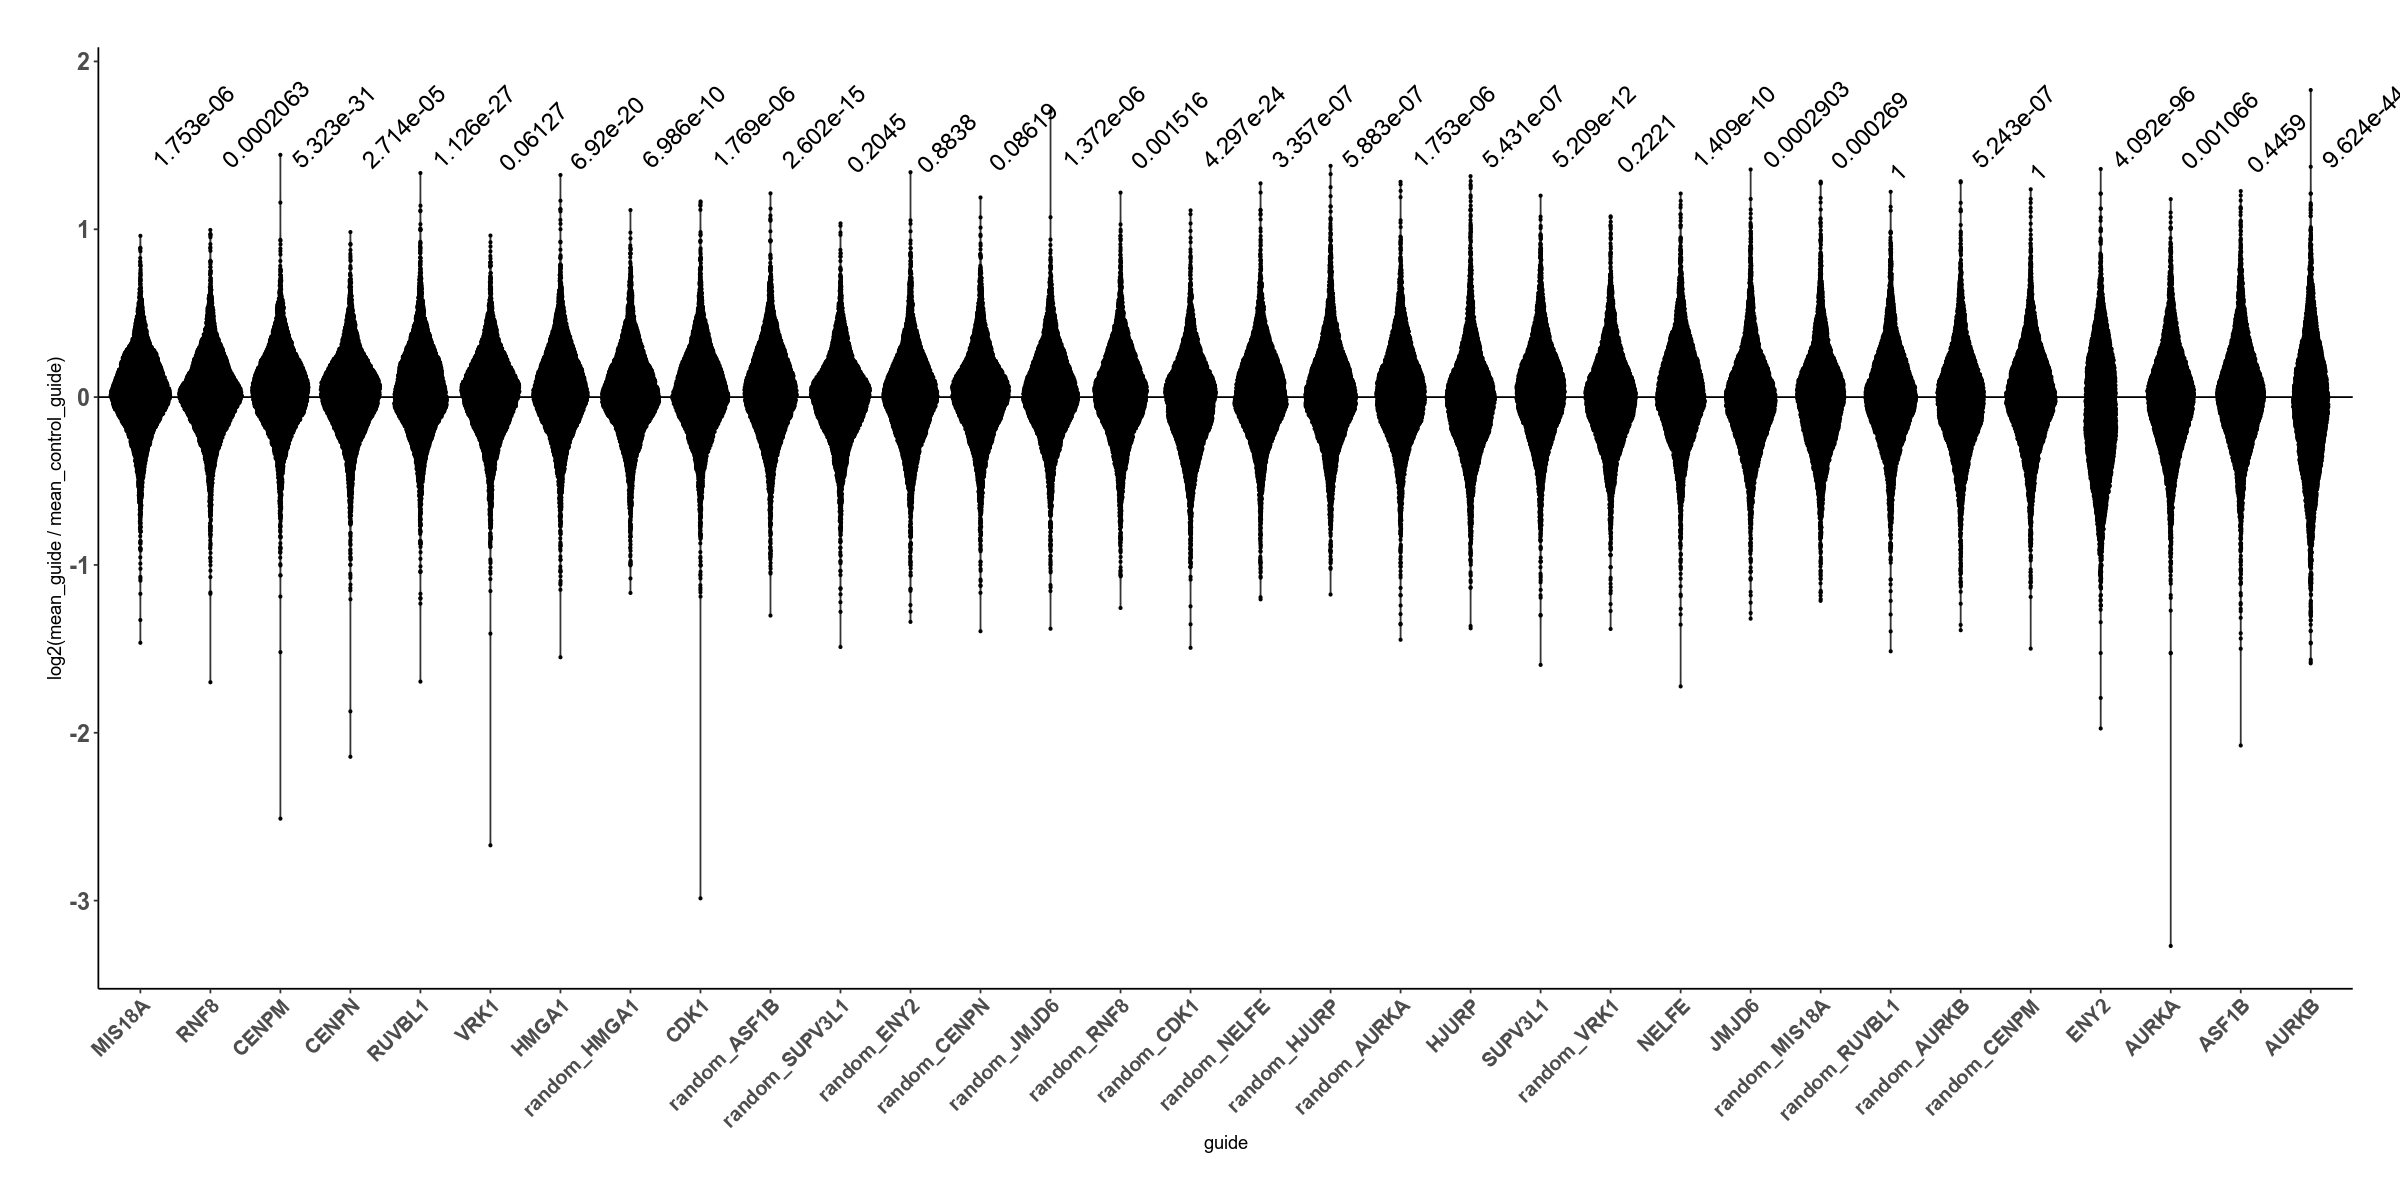

In [57]:
options(repr.plot.width=20, repr.plot.height=10)
library(ggforce)

ggplot(ratios_df, aes(guide, mean_gdmean_ctrlratio, fill = guide)) + ylab('log2(mean_guide / mean_control_guide)') +
  geom_violin(position=position_dodge()) + annotate("text", x = 1:length(plotted_guides), y = 1.3, size = 5, angle='45', hjust = -0.2, label = pvals_adj) +
  geom_sina(position=position_dodge(), size = 0.5) + geom_hline(yintercept = 0) + coord_cartesian(clip = 'off') +
  theme_classic() + theme(plot.margin = margin(1,1,1,1, "cm"), plot.title = element_text(hjust = 0.5), legend.position = 'none', axis.text.y = element_text(face = 'bold', size = 14), axis.text.x = element_text(face = 'bold', size = 12, angle = 45, hjust = 1)) 

In [61]:
ratios_df %>% group_by(guide) %>% summarize(mean = mean(mean_gdmean_ctrlratio)) %>% arrange(mean)

guide,mean
<fct>,<dbl>
ENY2,-0.101059486
AURKB,-0.069475962
random_CDK1,-0.036595930
HJURP,-0.021375043
random_AURKB,-0.021036722
random_MIS18A,-0.016195938
JMJD6,-0.015607243
AURKA,-0.015232727
random_VRK1,-0.007211049
